# Computational Methods in Simulation (CMIS) Week 1
This notebook is intended to help students make their hand-in in this week of CMIS.

Hand-ins must be submitted as a maximum 5 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 11 - follow the detailed steps below to learn about finite difference approximations and it's applications:

* Use a 4-by-4 grid for the small 2D Toy example from page 18 and apply the boundary conditions ∂u/∂x = 0  On all vertical boundaries and ∂u/∂y = 0 On all horizontal boundaries. Let f(x,y)=x+y and κ=2. 
* Draw the computational mesh
* Derive update formulas for the ghost nodes
* Derive update formulas for all domain nodes
* Explain how the approximation equations from the governing equations and boundary conditions are mapped into a matrix using index sets.
* Write code that assembles the full matrix system.
* Write code that assembles the corresponding matrix rows for the domain nodes.
* Write code that assembles the corresponding matrix rows for the ghost nodes
* Examine the fill pattern of the sub-block matrices from the Toy example. What can you say about them?
* Examine the eigenvalues of the full matrix system
* Speculate whether you can solve this linear system or not.

## Detailed Expected Learning Objectives in The Hand-in of this Week

* Finite Difference Methods (FDM) Part 1 (Lecture slides number 11)
    * Explain the idea of using Finite Difference Approximations.
    * Re-derive 1st order FD/BD/CD from Taylor series expansions, derive 2nd order CD from Taylor series expansion.
    * Define common terminology: A stencil, update scheme, computational mesh, matrix assembly etc.
    * Apply boundary conditions through FD/BD on boundary or ghost nodes.
    * Discuss pros and cons of an update scheme versus matrix assembly.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## The 2D TOY PDE problem

Solve 

$\nabla^2 u - k^2 u = f$,

given known $k > 0$ and $f(x,y)$

Use 

$\frac{\partial u}{\partial x} = 0$ 

for vertical boundaries. Use

$\frac{\partial u}{\partial y} = 0$ 

for horizontal boundaries

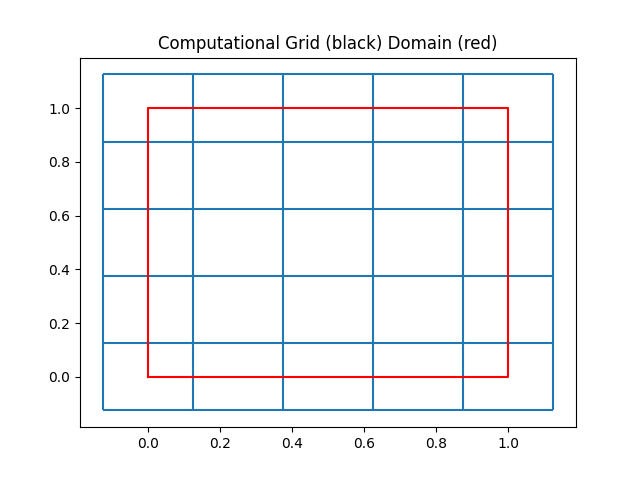

In [3]:
I, J = (6, 6)# Size of computational domain including ghost boundary
# First we compute the x and y coordinates of all nodes in the computational
# mesh. Observe that we carefully ensure that the the domain boundary is
# half-way between the ghost nodes and the interior boundary nodes.
dx     = 1/(I-2);
dy     = dx;
x = np.linspace(-dx/2,1+dx/2,I)
y = np.linspace(-dy/2,1+dy/2,J)

[X, Y]  = np.meshgrid(x,y)
U      = np.zeros((I,J),dtype=np.float64) 
k      = 2      # Just some arbitary value
f      = np.exp(-X**2 -Y**2)#np.ones_like(X) * 10

fig = plt.figure()
ax = plt.subplot(111)
plt.hlines(y, x[0], x[-1])
plt.vlines(x, y[0], y[-1])
plt.plot([0, 1, 1, 0, 0],[0,0,1, 1,0], color='r')
ax.set_title("Computational Grid (black) Domain (red)")
plt.savefig(f"grid{I}")
plt.show()

## Central diff approx are

We know from finite difference approximations that

$\frac{\partial^2 u}{\partial x^2} \approx  \frac{ u_{i+1,j} - 2 u_{i,j} + u_{i-1,j} }{\Delta x^2}$

$\frac{\partial^2 u}{\partial y^2} \approx  \frac{ u_{i,j+1} - 2 u_{i,j} + u_{i,j-1} }{\Delta y^2}$

Hence substituting into the Toy problem we obtain the approximation

$\nabla^2 u - k^2 u \approx c_{down} \, u_{i,j-1} +  c_{left}\, u_{i-1,j} + c_{mid} \,u_{i,j} + c_{right}\, u_{i+1,j} +  c_up \, u_{i,j+1}$

For all non-ghost nodes, $0<i<5$ and  $0<j<5$. Observe we assume that the lower left node in the domain has a zero-based index (0,0).

By method of equal coefficients we derive equations for the constants in the approximation given above.

In [4]:

# TODO - derive the update equations for the constants as in the example in the slides and define them here
c_left  = 1 / (dx  ** 2)
c_right = 1 / (dx ** 2 )
c_up    = 1 / (dy ** 2)
c_down  = 1 / (dy ** 2)
c_mid   = - k**2 - 2/(dx**2) - 2/(dy**2)

Next we will write up all the stencil's simultaneously into a coefficient matrix

In the following cells, it is your job to
* Add code to assemble matrix A
* Add code to assemble right hand side term b
* Replace below with u = A\b

In [5]:

D = [] # Index set of all domain nodes
G = [] # Index set of all ghost nodes

A = np.zeros((I*J,I*J), dtype=np.float64)  # The coefficient matrix of the full system
b = np.zeros((I*J,1), dtype=np.float64)    # The right hand side vector the full system

for j in range(1,I-1):
    for i in range(1,I-1):
        # TODO - Add code to assemble matrix A and right hand side term b using the hints below

        # Convert 2D index (i,j) into linear index space
        _k = j * I + i 
        D.append(_k)

        # Fill in the coefficient values into A and b

        A[_k, j*I+i]     = c_mid    
        A[_k, j*I+(i-1)] = c_left    
        A[_k, j*I+(i+1)] = c_right    
        A[_k, (j+1)*I+i] = c_up        
        A[_k, (j-1)*I+i] = c_down   

        b[_k] = f[i,j] # or f[i,j]


Before we handle the ghost nodes we will examine the assembly of the A-matrix

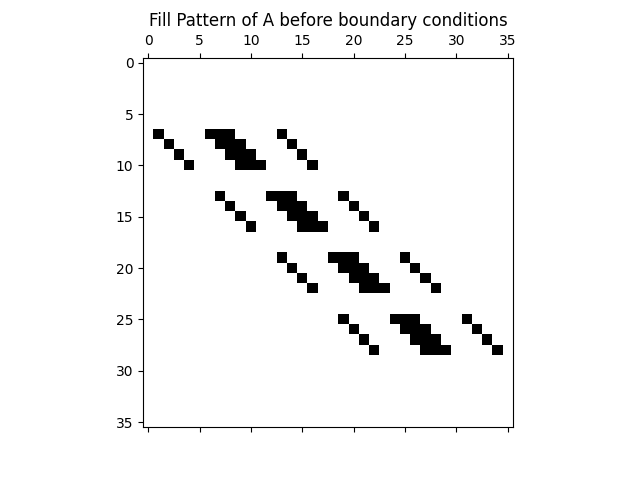

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(A)
ax.set_title("Fill Pattern of A before boundary conditions")
plt.savefig("matrix_asem.png")
plt.show()

Next we investigate the eigenvalues of A. We know that we have 20 ghost nodes that are currently not accounted for. Further, We know that the Laplacian has negative eigenvalues. Hence, as we have 16 internal nodes, we must have 16 negative eigenvalues and 20 zero eigenvalues.

In 2D the Laplacian operator has 4 zero eigenvalues (any plane would be a solution, hence 4 numbers are free to choose). One may ask why should we not expect 24 zero-eigenvalues? That is because the 4 eigenmodes are shared by the ghost nodes on this grid. If we did the assembly without grid nodes then we would only find 4 zero eigenvalues.

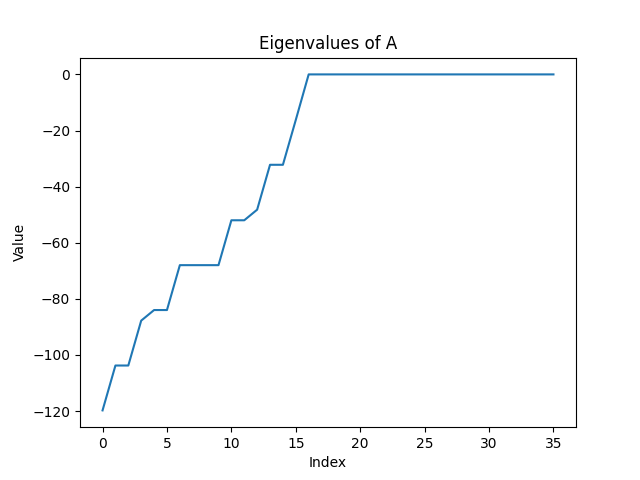

In [7]:
d,_ = np.linalg.eig(A)

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(np.sort(d))
ax.set_title("Eigenvalues of A")
ax.set_xlabel("Index")
ax.set_ylabel("Value")
plt.show()

In [8]:
np.sort(d)

array([-119.77708764, -103.77708764, -103.77708764,  -87.77708764,
        -84.        ,  -84.        ,  -68.        ,  -68.        ,
        -68.        ,  -68.        ,  -52.        ,  -52.        ,
        -48.22291236,  -32.22291236,  -32.22291236,  -16.22291236,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

We can now continue adding stencils of the ghost nodes. First we handle the left and right boundary conditions at $x=0$ and $x=$. Here we find all $0<j<5$

$\left(\frac{\partial u}{\partial x}\right)_{\tfrac{1}{2}, j} \approx u_{1,j} - u_{0,j} = 0$

This means we have $u_{0,j} = u_{1,j}$. Similary for the right bouyndary

$\left(\frac{\partial u}{\partial x}\right)_{4+\tfrac{1}{2}, j} \approx u_{5,j} - u_{4,j} = 0$

From this we find  $u_{5,j} = u_{4,j}$

In the following cells, you need to add the stencils for the ghost nodes

In [9]:

i = 0
for j in range(1,J-1):
    # TODO - Now we add the stencil for ghost node (i,j) to A and b
    ghost   = j*I
    domain  = ghost + 1 
    # NOTE: When doing matrix mul then we need the zero
    # we get this using these coefficients
    A[ghost,ghost]  = -1
    A[ghost,domain] = 1 
    b[ghost] = 0
    G.append(ghost)
i = I - 1#5
for j in range(1,J-1):
    # TODO - Now we add the stencil for ghost node (i,j) to A and b
    ghost   = i+j*I
    domain  = ghost - 1
    A[ghost,ghost] = 1
    A[ghost,domain] = -1
    b[ghost] = 0
    G.append(ghost)    

In a similar fashion we can handle the top and bottom boundaries of our domain

Here we find all $0<i<5$

$\left(\frac{\partial u}{\partial y}\right)_{i, \tfrac{1}{2}} \approx u_{i,1} - u_{i,0} = 0$

Similary for the top bouyndary

$\left(\frac{\partial u}{\partial y}\right)_{i,4+\tfrac{1}{2}} \approx u_{i,5} - u_{i,4} = 0$

In [10]:
j = 0
for i in range(1,I-1):
    # TODO - Now we add the stencil for ghost node (i,j) to A and b
    ghost = i
    domain = ghost + I
    A[ghost,ghost] =  -1
    A[ghost,domain] = 1
    b[ghost] = 0
    G.append(ghost)    
j = J - 1#5
for i in range(1,I-1):
    # TODO - Now we add the stencil for ghost node (i,j) to A and b
    ghost = j*I + i
    domain = ghost - I
    A[ghost,ghost] = 1
    A[ghost,domain] = -1
    b[ghost] = 0
    G.append(ghost)   

Ghost corner cells have no influence on grid so we just set them to some values. If we do nothing then we will get into trouble as the A matrix will have a zero row for each corner ghost node. That will make A singular.

In [11]:

i=0
j=0
ghost = I*j+i
A[ghost,ghost] = 1
b[ghost] = 0
G.append(ghost)

i=I - 1#5
j=0
ghost = I*j+i
A[ghost,ghost] = 1
b[ghost] = 0
G.append(ghost)

i=0
j=J-1#5
ghost = I*j+i
A[ghost,ghost] = 1
b[ghost] = 0
G.append(ghost)

i=I-1#5
j=I-1#5
ghost = I*j+i
A[ghost,ghost] = 1
b[ghost] = 0
G.append(ghost)

Now we will verify if our boundary conditions was correctly assembled into the A matrix and that the A matrix is non-singular so we can solve our discrete PDE.

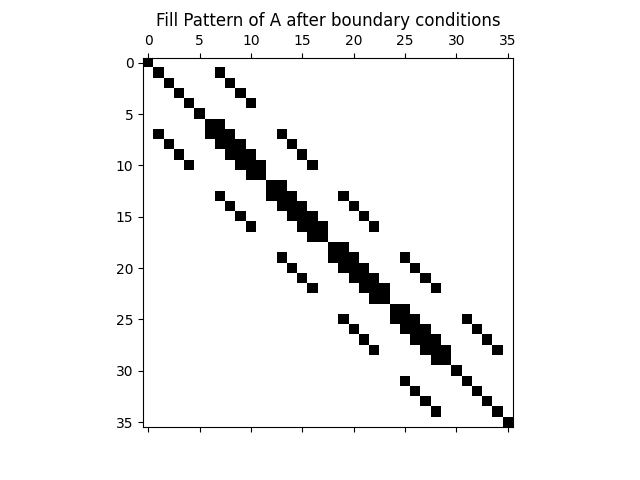

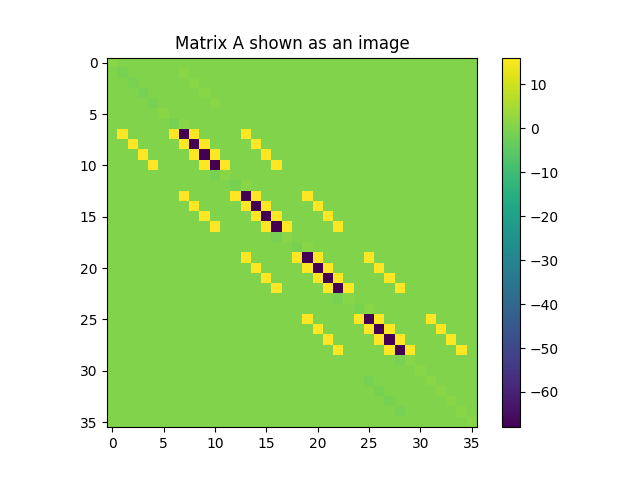

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(A)
ax.set_title("Fill Pattern of A after boundary conditions")
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
plt.imshow(A)
ax.set_title("Matrix A shown as an image")
plt.colorbar()
plt.show()

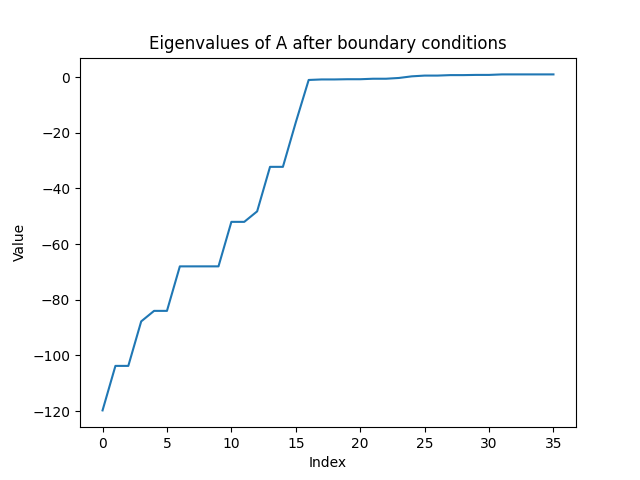

In [13]:
d,_ = np.linalg.eig(A)

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(np.sort(d))
ax.set_title("Eigenvalues of A after boundary conditions")
ax.set_xlabel("Index")
ax.set_ylabel("Value")
plt.show()

In [14]:
np.sort(d)

array([-119.77820304, -103.77923788, -103.77923788,  -87.78102177,
        -84.00226781,  -84.00226781,  -68.0050076 ,  -68.0050076 ,
        -68.00191346,  -68.00191346,  -52.00591773,  -52.00591773,
        -48.22979097,  -32.23142646,  -32.23142646,  -16.2293236 ,
         -1.        ,   -0.81367937,   -0.81367937,   -0.7369766 ,
         -0.7369766 ,   -0.5583518 ,   -0.5583518 ,   -0.28275755,
          0.30109693,    0.57403062,    0.57403062,    0.74349816,
          0.74349816,    0.81724994,    0.81724994,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ])

Observe that the full matrix A is no longer a symmetric matrix after having added the boundary conditions. Hence, the eigenvalues are now complex numbers and no longer reals.

Finally we can now solve our discretized PDE problem. Observe that the solution will be given in the one-dimensional index space of the matrix system. Hence, to be able to visualize the solution we must convert back to the 2D index space.

When we show the solution we want to clip away the ghost boundary.

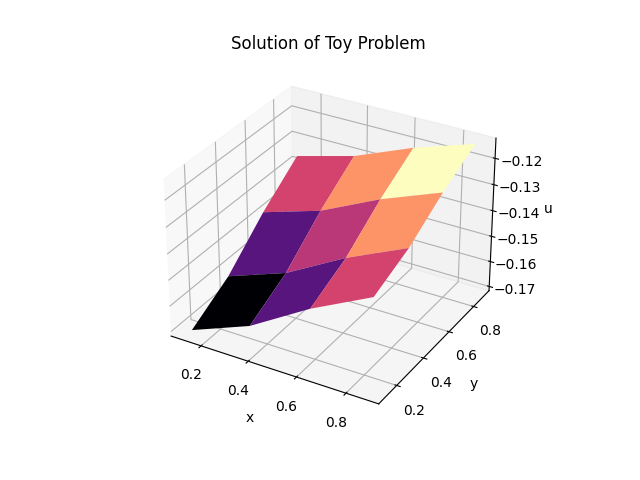

In [15]:

u = np.linalg.solve(A,b)

U = np.zeros((I,J),dtype=np.float64)
for i in range(I):
    for j in range(J):
        idx = I*j+i
        U[i,j] = u[idx]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X[1:I-1,1:J-1],Y[1:I-1,1:J-1],U[1:I-1,1:J-1],cmap="magma", color='0.75', rstride=1, cstride=1)
ax.set_title("Solution of Toy Problem")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")
plt.savefig(f"solution{I}-gaussian.png")
plt.show()

* Grid size 6x6
-0.22831632653061257
* Grid size 12 x 12
-0.22431437282699201
* Grid size 24 x 24
-0.22287363604461982
* Grid size 48 x 48
-0.22224887248121095
* Grid size 96 x 96
-0.22195670144106935

## Another note on Eigenvalues:

While it is often useful as a guideline, the number of zero eigenvalues of our matrix A is not always related to the number of needed boundary conditions. The only thing a zero eigenvalue tells us, is that the discrete system is not well-posed and as such suggests that a modelling (we are missing some information) or discretization (we discretized our governing euqation wrongly) error was performed in earlier steps. Further, adding a boundary condition to a linear system is not the same as adding more rows to an underdetermined system. The reason is that boundary conditions modify both columns and rows when added. 

# Alternative solution: Shur reduction of the above 

Sofar we have solved the TOY problem by assembling a full system of equations and then solve the full system without exploiting any knowledge about domain nodes and ghost nodes. We will make a partitioning of the full system into small blocks and analyse these individually.

$
\begin{bmatrix}
A_{D,D} & A_{D,G} \\
A_{G,D} & A_{G,G} 
\end{bmatrix}
\begin{bmatrix}
u_{D} \\ u_{G}
\end{bmatrix}
=
\begin{bmatrix}
b_{D} \\ b_{G}
\end{bmatrix}
$

where $D$ is the index set of domain nodes and $G$ is the index set of the ghost nodes

In [16]:
ADD = (A[D,:])[:,D]
ADG = (A[D,:])[:,G]
AGD = (A[G,:])[:,D]
AGG = (A[G,:])[:,G]
bD = b[D]
bG = b[G]

Next we will create the Schur reduction.

In our case AGG has either 1 or -1 on the diagonal. It means that it is its own inverse. That is

$A_{G,G}^{-1} = A_{G,G}$

This makes the Schur complement particular easy to compute for us. The Schur matrix has the benefit of being of lower dimension of A hence it is more efficient to solve the Schur system. Further, the Schur matrix is symmetric and definite.

In our case the Schur matrix will be negative definite due to the Laplace operator. However, if the entire Shur equation is multiplied by minus one then one can solve for $u$ using an iterative fast solver such as preconditioned conjugate gradient.

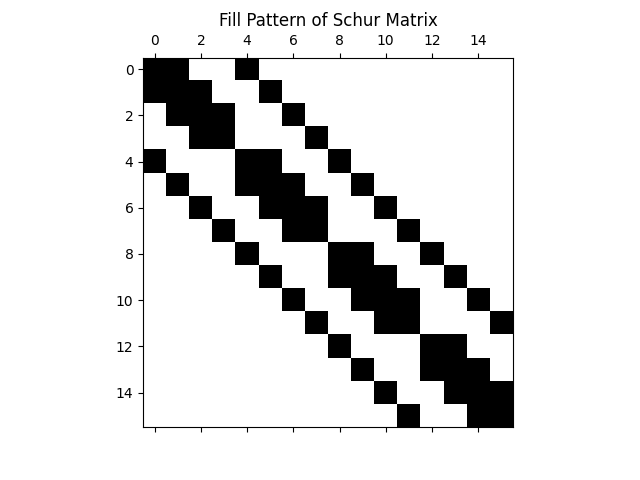

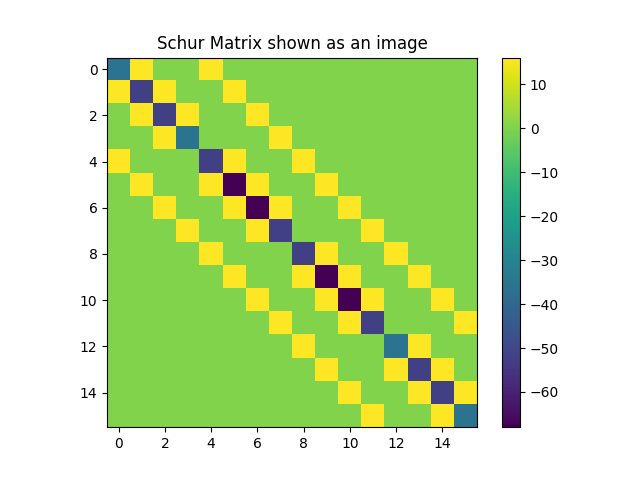

In [17]:
S = ADD - np.dot(ADG,np.dot(AGG,AGD))
c = bD - np.dot(ADG,np.dot(AGG,bG))

fig = plt.figure()
ax = plt.subplot(111)
plt.spy(S)
ax.set_title("Fill Pattern of Schur Matrix")
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
plt.imshow(S)
ax.set_title("Schur Matrix shown as an image")
plt.colorbar()
plt.show()

#d,_ = np.linalg.eig(S)
#
#fig = plt.figure()
#ax = plt.subplot(111)
#plt.plot(np.sort(d))
#ax.set_title("Eigenvalues of Schur Matrix")
#ax.set_xlabel("Index")
#ax.set_ylabel("Value")
#plt.show()

Finally, we will compute the solution for $u$ using the Schur complement and compare it against the solution of $u$ computed with the full system. It is interesting to know if this error is close the machine epsilon.

In [18]:
uD = np.linalg.solve(S,c)

error = np.linalg.norm(uD-u[D]) / np.linalg.norm(u[D])
print('The relative error between Schur complement solution and full system solution is ', error)

print(np.finfo(dtype=np.float64))

The relative error between Schur complement solution and full system solution is  1.8597107611957805e-15
Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------



That is all folks!